# Heart Failure Prediction - Jason Pereira

## 1. Import Necessary Libraries

In [14]:
#First, import the necessary libraries for data manipulation, analysis, and visualization.
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import shap
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
from sklearn.metrics import confusion_matrix
import pickle



## 2. Load the Dataset

In [15]:
# Load the dataset into a DataFrame.

df = pd.read_csv('../data/heart.csv')


## 3. Exploratory Data Analysis

In [16]:
#Explore the dataset to understand its structure and content.

# View the first few rows of the dataset
print(df.head())

# Get information about the dataset
print(df.info())

# Check for missing values
print(df.isnull().sum())


   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age    

In [17]:
# Define the output directory path
output_dir = '../output'

# Ensure the output directory exists
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Output directory '{output_dir}' created.")
else:
    print(f"Output directory '{output_dir}' already exists.")

Output directory '../output' already exists.


### 3.1. Visualize numerical variable distribution

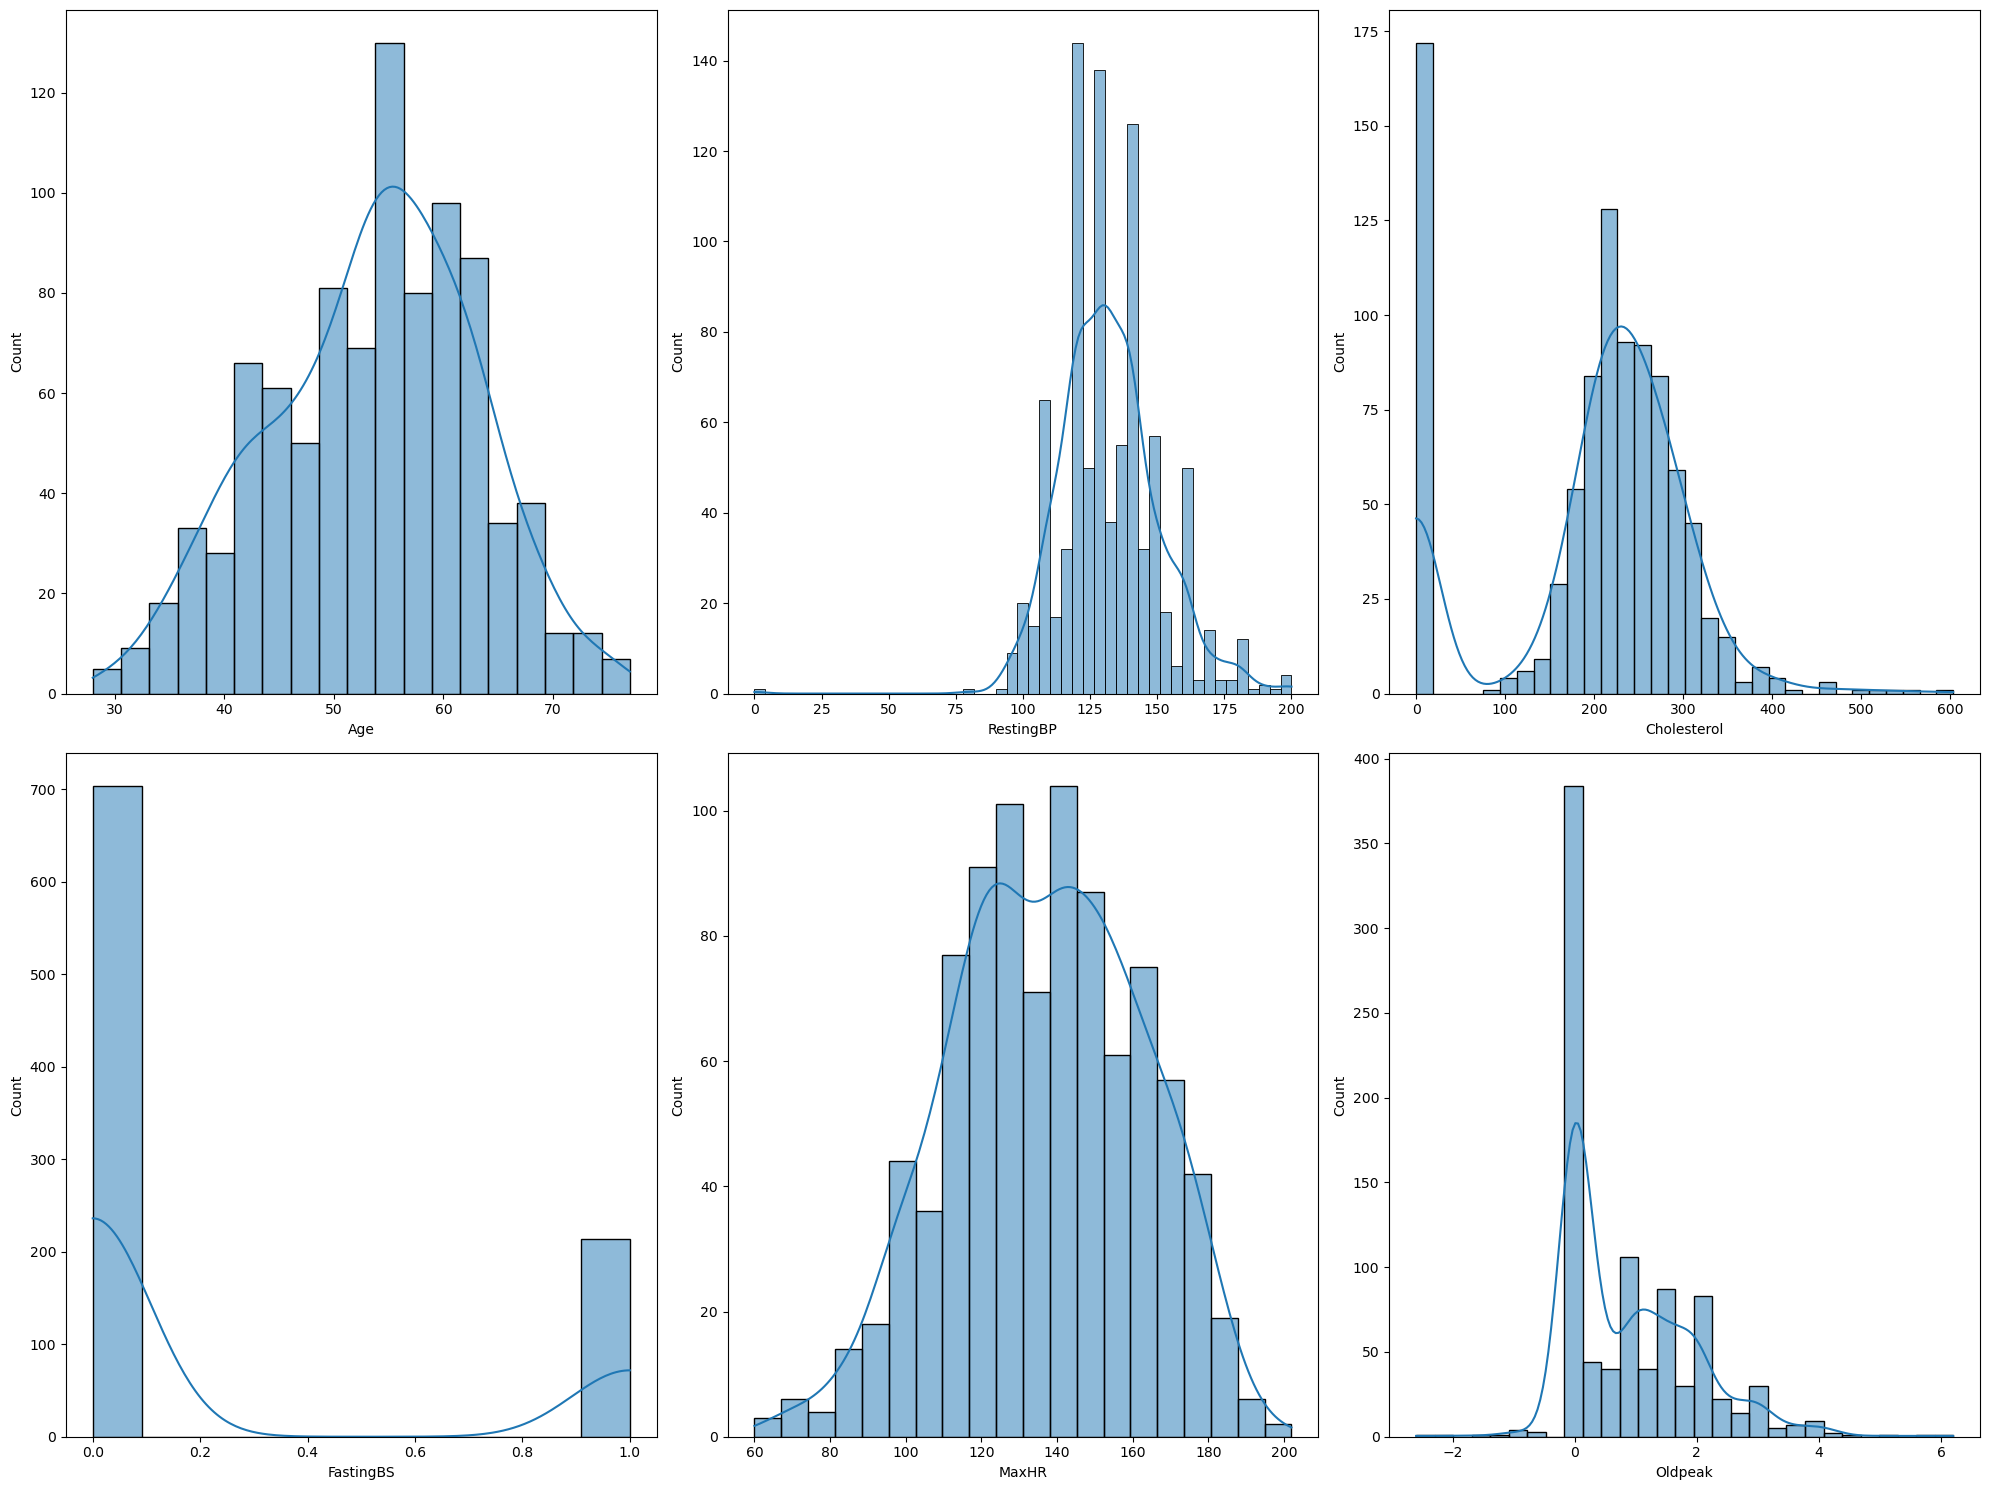

Plot saved to ../output\numerical_features_histogram.png


In [18]:
# Plot a histogram for each numerical feature
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
sns.histplot(df['Age'], ax=axes[0, 0], kde=True)
sns.histplot(df['RestingBP'], ax=axes[0, 1], kde=True)
sns.histplot(df['Cholesterol'], ax=axes[0, 2], kde=True)
sns.histplot(df['FastingBS'], ax=axes[1, 0], kde=True)
sns.histplot(df['MaxHR'], ax=axes[1, 1], kde=True)
sns.histplot(df['Oldpeak'], ax=axes[1, 2], kde=True)

plt.tight_layout()

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'numerical_features_histogram.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")

### 3.2 Analysis of the Attached Dataset Distributions

The histograms deptict six numerical features from a heart disease dataset: Age, RestingBP, Cholesterol, FastingBS, MaxHR, and Oldpeak. Each histogram provides insights into the distribution and characteristics of these features, which are crucial for understanding the dataset and its implications for heart disease prediction.  

#### 1. Age  
    Distribution: Approximately normal distribution, centered around 50–60 years.  
    Range: Ages span from around 30 to 70+ years.  

    Insights:  
    The dataset primarily represents middle-aged to older individuals, which aligns with the demographic most at risk for heart disease.  

    This feature is likely important for prediction, as age is a known risk factor for cardiovascular conditions.  

#### 2. RestingBP (Resting Blood Pressure)  
    Distribution: Slightly right-skewed, with most values concentrated between 120–140 mmHg.  
    Range: Values span from very low (<80 mmHg) to high (>200 mmHg).  

    Insights:  
    While most values fall within a normal range, some extreme values may indicate outliers or individuals with hypertension.  

    Resting blood pressure is a relevant predictor of heart disease, but its weak correlation with heart disease (as noted earlier) suggests it may not be a primary driver in this dataset.  

#### 3. Cholesterol  
    Distribution: Right-skewed, with a peak around 200–250 mg/dL.  
    Range: Values extend from very low (<100 mg/dL) to extremely high (>500 mg/dL).  

    Insights:  
    The majority of individuals fall within borderline to high cholesterol levels, which are common risk factors for heart disease.  

    The long tail of high cholesterol values may represent individuals with severe hyperlipidemia, requiring medical attention.  

#### 4. FastingBS (Fasting Blood Sugar)  
    Distribution: Binary distribution (0 and 1), indicating whether fasting blood sugar is >120 mg/dL (1) or ≤120 mg/dL (0).  

    Insights:  
    Most individuals have normal fasting blood sugar levels (0), while a smaller group has elevated levels (1).  

    Elevated fasting blood sugar is associated with diabetes, which is a known risk factor for heart disease.  

#### 5. MaxHR (Maximum Heart Rate Achieved)
    Distribution: Slightly left-skewed, with most values concentrated between 140–160 bpm.  

    Range: Values span from low (<100 bpm) to high (>200 bpm).  

    Insights:  
    Higher maximum heart rates are generally associated with younger individuals or better cardiovascular fitness, while lower values may indicate age-related decline or cardiac issues.  

    This feature is important for prediction, as its moderate negative correlation with age suggests physiological trends relevant to heart health.  

#### 6. Oldpeak (ST Depression Induced by Exercise Relative to Rest)  
    Distribution: Right-skewed, with most values concentrated around 0–1.  
    Range: Values extend from negative (<0) to high (>4).  

    Insights:  

    Higher Oldpeak values indicate significant ST depression during exercise, which is strongly associated with ischemia and heart disease.  

    This feature is highly predictive of heart disease due to its direct link to cardiac stress and ischemia.  

### Summary of Feature Insights  
    Features like Age, MaxHR, and Oldpeak exhibit distributions that align well with their known importance in predicting heart disease. These features are likely strong predictors based on their medical relevance and statistical characteristics.  

    Features like RestingBP and Cholesterol show variability but may contribute less directly to predictions due to weaker correlations observed earlier.  

    The binary nature of FastingBS simplifies its interpretation but highlights its importance as an indicator of diabetes-related risk.  

### Recommendations for Data Preprocessing:  
    Outlier Handling: Extreme values in features like RestingBP and Cholesterol should be examined further to determine if they represent valid data points or require removal/imputation.  

    Scaling: Features like Oldpeak, MaxHR, and Cholesterol may benefit from scaling (e.g., standardization or normalization) due to their wide ranges.  

    Feature Engineering: Consider interactions between features like Age, MaxHR, and Oldpeak, as they may provide additional predictive power for heart disease classification.  

## 4. Preprocess the Data

### 4.1. Handle Missing and Zero Values

In [19]:
# Check if there are any missing values
if df.isnull().values.any():
    # Fill missing values with mean for numerical columns and mode for categorical columns
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna(df[col].mode()[0])
        else:
            df[col] = df[col].fillna(df[col].mean())
else:
    print("No missing values found.")


No missing values found.


In [20]:
# Identify features with zero values
clinical_features = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR']
zero_counts = {feature: (df[feature] == 0).sum() for feature in clinical_features}

# Create a DataFrame to summarize zero counts
zero_summary = pd.DataFrame(list(zero_counts.items()), columns=['Feature', 'Zero Count'])
zero_summary['Percentage'] = (zero_summary['Zero Count'] / len(df)) * 100

print(zero_summary)

       Feature  Zero Count  Percentage
0          Age           0    0.000000
1    RestingBP           1    0.108932
2  Cholesterol         172   18.736383
3    FastingBS         704   76.688453
4        MaxHR           0    0.000000


### 4.2. Visualize the numerical features with Zero counts

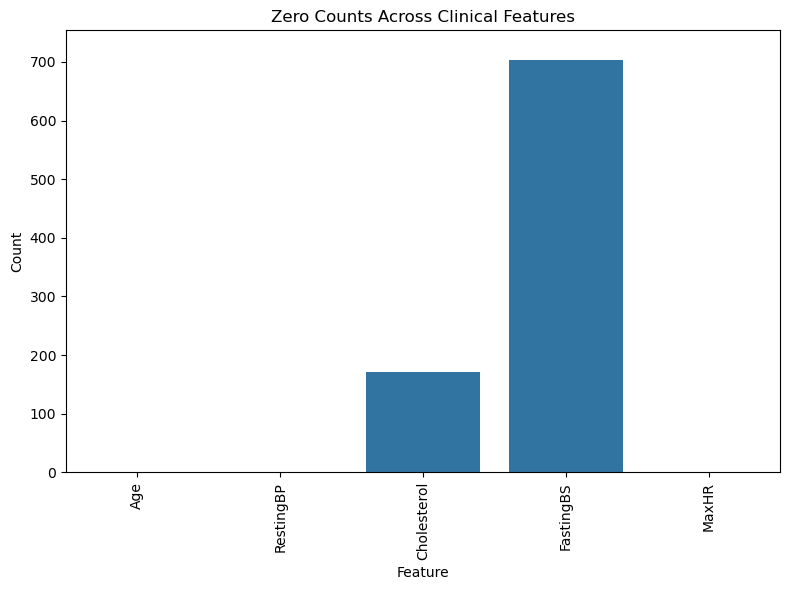

Plot saved to ../output\zero_counts_bar_chart.png


In [21]:
# Plot a bar chart to visualize zero counts
plt.figure(figsize=(8, 6))
sns.barplot(x='Feature', y='Zero Count', data=zero_summary)
plt.title('Zero Counts Across Clinical Features')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.ylim(0, zero_summary['Zero Count'].max() + 50)  # Adjust the y-axis limit
plt.xticks(rotation=90)
plt.tight_layout()

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'zero_counts_bar_chart.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")


## 5. Feature Engineering

In [22]:
# Define categorical columns
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Apply one-hot encoding
encoded_features = encoder.fit_transform(df[categorical_cols])

# Create a DataFrame for the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns and concatenate the encoded features
df_encoded = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

print(df_encoded.head())

   Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0   40        140          289          0    172      0.0             0   
1   49        160          180          0    156      1.0             1   
2   37        130          283          0     98      0.0             0   
3   48        138          214          0    108      1.5             1   
4   54        150          195          0    122      0.0             0   

   Sex_M  ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  \
0    1.0                1.0                0.0               0.0   
1    0.0                0.0                1.0               0.0   
2    1.0                1.0                0.0               0.0   
3    0.0                0.0                0.0               0.0   
4    1.0                0.0                1.0               0.0   

   RestingECG_Normal  RestingECG_ST  ExerciseAngina_Y  ST_Slope_Flat  \
0                1.0            0.0               0.0            0.0

### 5.1. Correlation Matrix

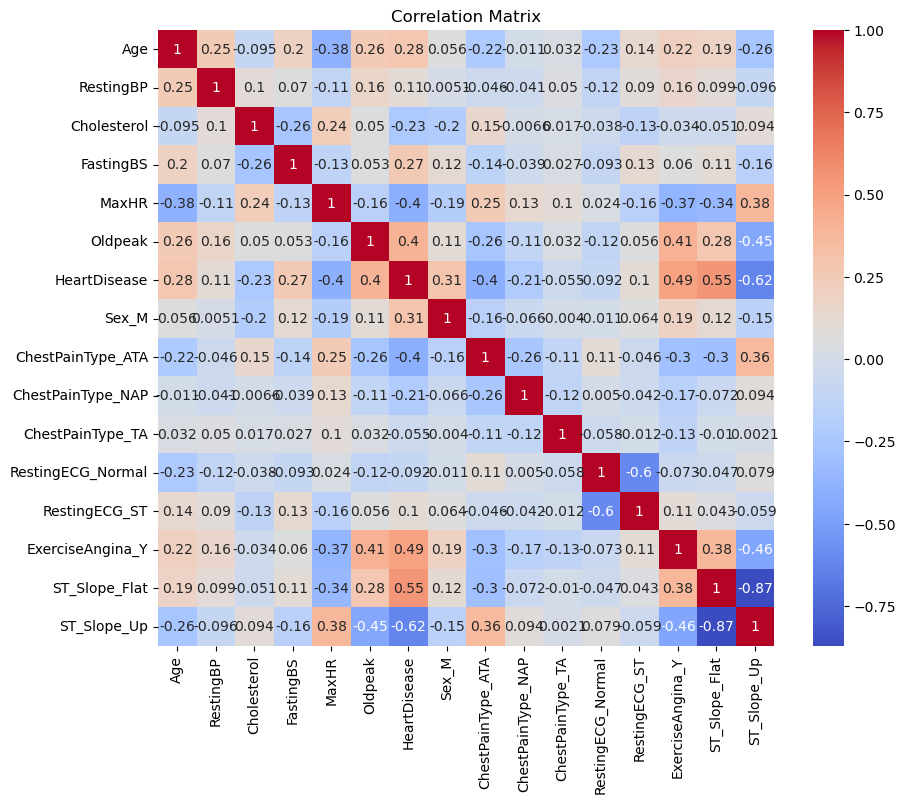

Plot saved to ../output\correlation_matrix.png


In [23]:
# Plot a heatmap to visualize correlations
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'correlation_matrix.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")


### 5.2. Correlation Analysis - Key Observations

Heart Disease and the presense of Exercise Angina has a strong positive correlation (r = 0.49) confirming that individuals with exercise-induced angina are more likely to have heart disease.  

Heart Disease and a flat ST_Slope's strong positive correlation (r = 0.55) indicates that a flat ST slope is a significant predictor of heart disease, consistent with clinical findings.  

Heart Disease and Oldpeak have moderate positive correlation (r = 0.40) suggests that higher Oldpeak values (indicative of ST segment depression) are associated with an increased likelihood of heart disease.    

The strong negative correlation betwen heart disease and ST_Slope_Up (r = -0.62) implies that an upward-sloping ST segment is linked to a lower risk of heart disease, potentially serving as a protective factor.  

Features like Resting BP and Cholesterol show weak correlations with heart disease (r = 0.11 and r = 0.23, respectively) suggesting these variales may not be strong standalone predictors of heart disease.

Summary:
Features such as "ExerciseAngina_Y," "ST_Slope_Flat," and "Oldpeak" show strong correlations with "HeartDisease," making them significant predictors.

Features like "RestingBP" and "Cholesterol" have weaker correlations, indicating they may contribute less to predicting heart disease directly.

Negative correlations, such as "ST_Slope_Up," suggest protective factors or lower risk associations.


Other insights:
The moderate neagitive correlation (r = -0.38) between Max Heart Rate and Age highlights the physiological decline in maximum heart rate as age increases, which aligns with established medical knowledge.  


### 5.3. Creating New Features

In [24]:
# Create age groups
df_encoded['AgeGroup'] = pd.cut(df_encoded['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
df_encoded = pd.get_dummies(df_encoded, columns=['AgeGroup'], drop_first=True)

# Create cholesterol level categories
df_encoded['CholesterolLevel'] = pd.cut(df_encoded['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
df_encoded = pd.get_dummies(df_encoded, columns=['CholesterolLevel'], drop_first=True)

#Feature Scaling

# Scale numerical features
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

## 6. Split the Data

Focusing on the most important features for the model as per correlation analysis: 'Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up'

In [25]:
# Split Data
# Define features (X) and target (y)
selected_features = [
    'Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up',
    'AgeGroup_Adult', 'AgeGroup_MiddleAged', 'AgeGroup_Senior',
    'CholesterolLevel_Medium', 'CholesterolLevel_High'
]
X = df_encoded[selected_features]
y = df_encoded['HeartDisease']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


## 7. Model and Feature Selection

In [26]:
# Define pipelines for different models

pipelines = {
    'RandomForest': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ]),
    'DecisionTree': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42))
    ])
}

# Print the pipelines to verify
for name, pipeline in pipelines.items():
    print(f"{name} pipeline created.")

RandomForest pipeline created.
XGBoost pipeline created.
KNN pipeline created.
DecisionTree pipeline created.
LogisticRegression pipeline created.


In [27]:
# Train all models in the pipeline and evaluate feature importance for Random Forest
trained_models = {}
feature_importances_df = None

for name, pipeline in pipelines.items():
    print(f"Training {name} model...")
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

    # If the model is Random Forest, extract feature importances
    if name == 'RandomForest':
        rfc = pipeline.named_steps['classifier']
        feature_importances_df = pd.DataFrame({'Feature': X_train.columns,
                                               'Importance': rfc.feature_importances_})
        feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)
        print(feature_importances_df)

# Select top features based on importance threshold from Random Forest
if feature_importances_df is not None:
    selector = SelectFromModel(rfc, threshold=0.05)
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Get selected feature names
    selected_features_final = X_train.columns[selector.get_support()]
    print("Selected Features:", selected_features_final)


Training RandomForest model...
                    Feature  Importance
1                     MaxHR    0.204119
2                   Oldpeak    0.175211
5               ST_Slope_Up    0.167999
0                       Age    0.142490
4             ST_Slope_Flat    0.133767
3          ExerciseAngina_Y    0.103510
9   CholesterolLevel_Medium    0.023101
10    CholesterolLevel_High    0.021380
8           AgeGroup_Senior    0.010875
6            AgeGroup_Adult    0.009013
7       AgeGroup_MiddleAged    0.008535
Training XGBoost model...


c:\Users\Jason\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:44:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training KNN model...
Training DecisionTree model...
Training LogisticRegression model...
Selected Features: Index(['Age', 'MaxHR', 'Oldpeak', 'ExerciseAngina_Y', 'ST_Slope_Flat',
       'ST_Slope_Up'],
      dtype='object')


## 8. Hyperparameter Tuning

In [28]:
# Perform hyperparameter tuning for all models in the pipeline
warnings.filterwarnings('ignore')
# Define hyperparameter grids for each model
param_grids = {
    'RandomForest': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 5],
        'classifier__max_features': ['auto', 'sqrt']
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 200],
        'classifier__max_depth': [3, 5, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'DecisionTree': {
        'classifier__max_depth': [None, 5, 10],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 5]
    },
    'LogisticRegression': {
        'classifier__C': [0.01, 0.1, 1, 10],
        'classifier__penalty': ['l2'],
        'classifier__solver': ['lbfgs', 'liblinear']
    }
}

# Perform GridSearchCV for each pipeline
best_models = {}
for name, pipeline in pipelines.items():
    print(f"Tuning hyperparameters for {name}...")
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best Parameters for {name}:", grid_search.best_params_)
    print(f"Best Score for {name}: {grid_search.best_score_:.4f}")

    print()

    # Print the best model based on the highest score
    best_model_name = max(best_models, key=lambda name: grid_search.best_score_)




Tuning hyperparameters for RandomForest...
Best Parameters for RandomForest: {'classifier__max_depth': 5, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
Best Score for RandomForest: 0.8501

Tuning hyperparameters for XGBoost...
Best Parameters for XGBoost: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'classifier__subsample': 1.0}
Best Score for XGBoost: 0.8474

Tuning hyperparameters for KNN...
Best Parameters for KNN: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}
Best Score for KNN: 0.8433

Tuning hyperparameters for DecisionTree...
Best Parameters for DecisionTree: {'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Best Score for DecisionTree: 0.8256

Tuning hyperparameters for LogisticRegression...
Best Parameters for LogisticRegression: {'

## 8.1. Visualize the feature importance

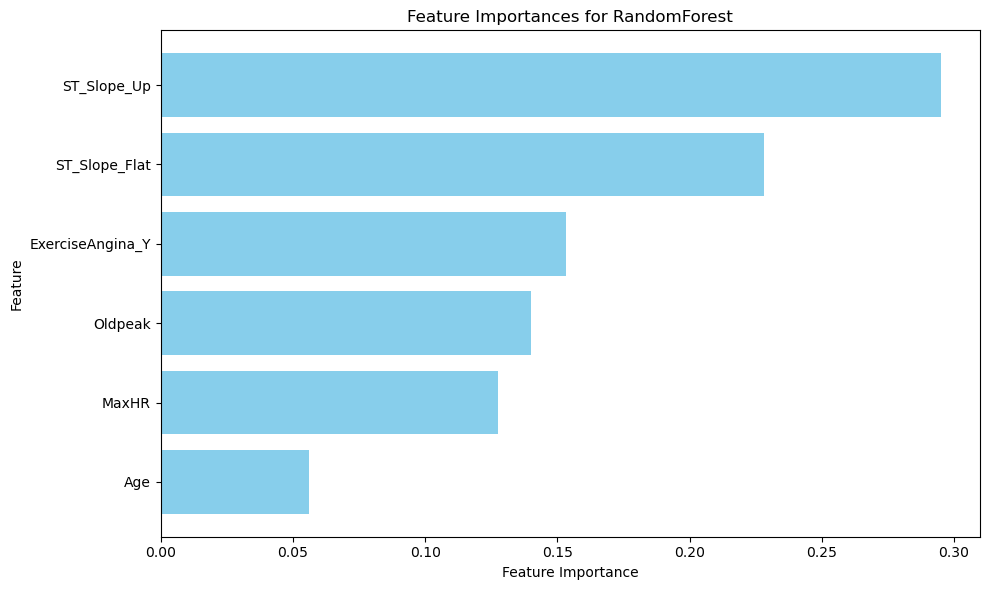

Feature importance plot saved to ../output\RandomForest_feature_importances.png


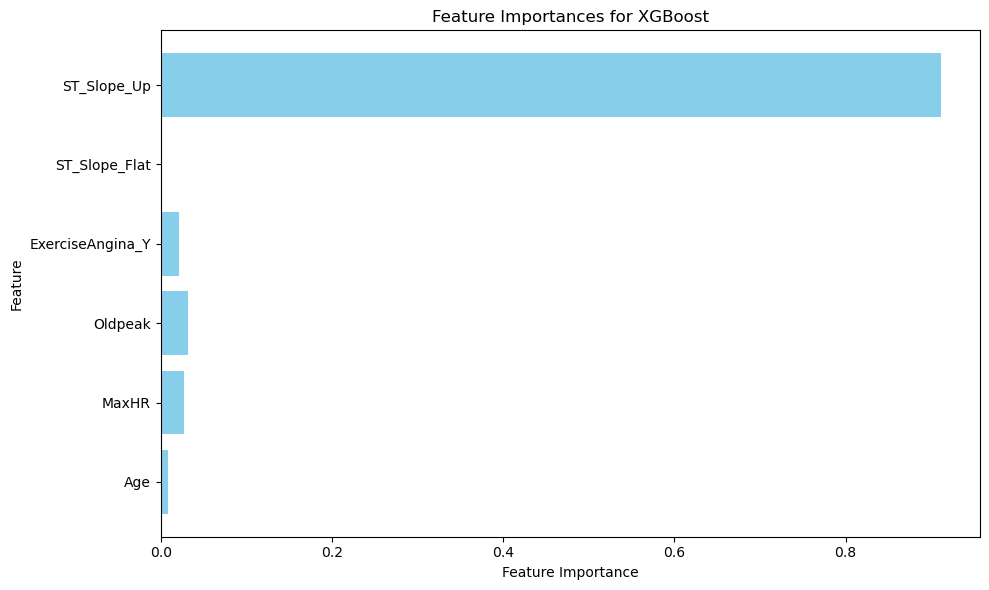

Feature importance plot saved to ../output\XGBoost_feature_importances.png
The model KNN does not support feature importances.


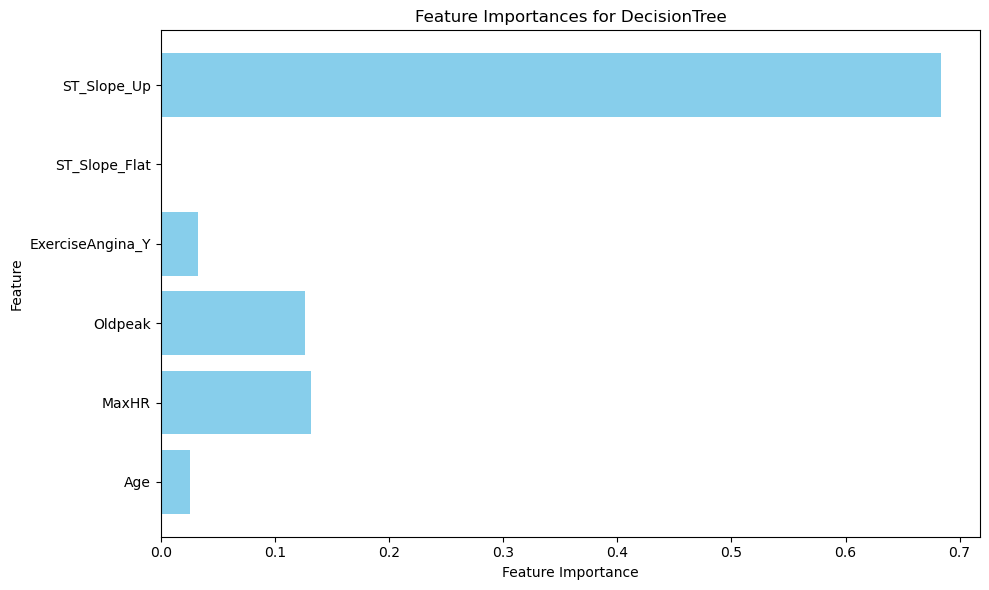

Feature importance plot saved to ../output\DecisionTree_feature_importances.png
The model LogisticRegression does not support feature importances.


In [29]:
    # Visualize the feature importances for all models if applicable
    for model_name, model in best_models.items():
        if hasattr(model.named_steps['classifier'], 'feature_importances_'):
            importances = model.named_steps['classifier'].feature_importances_
            feature_names = selected_features_final
            plt.figure(figsize=(10, 6))
            plt.barh(feature_names, importances, color='skyblue')
            plt.xlabel('Feature Importance')
            plt.ylabel('Feature')
            plt.title(f'Feature Importances for {model_name}')
            plt.tight_layout()

            # Save the plot to the output directory
            plot_path = os.path.join(output_dir, f'{model_name}_feature_importances.png')
            plt.savefig(plot_path)
            plt.show()

            print(f"Feature importance plot saved to {plot_path}")
        else:
            print(f"The model {model_name} does not support feature importances.")

### 8.2 Visualize the hyperparameter heatmap

Visualizing hyperparameter heatmap for RandomForest...


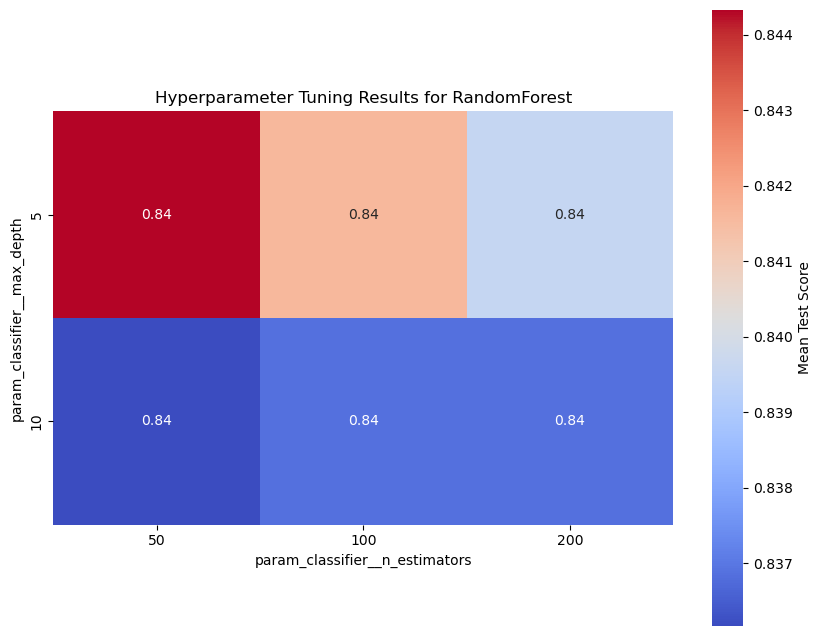

Plot saved to ../output\RandomForest_hyperparameter_heatmap.png
Visualizing hyperparameter heatmap for XGBoost...


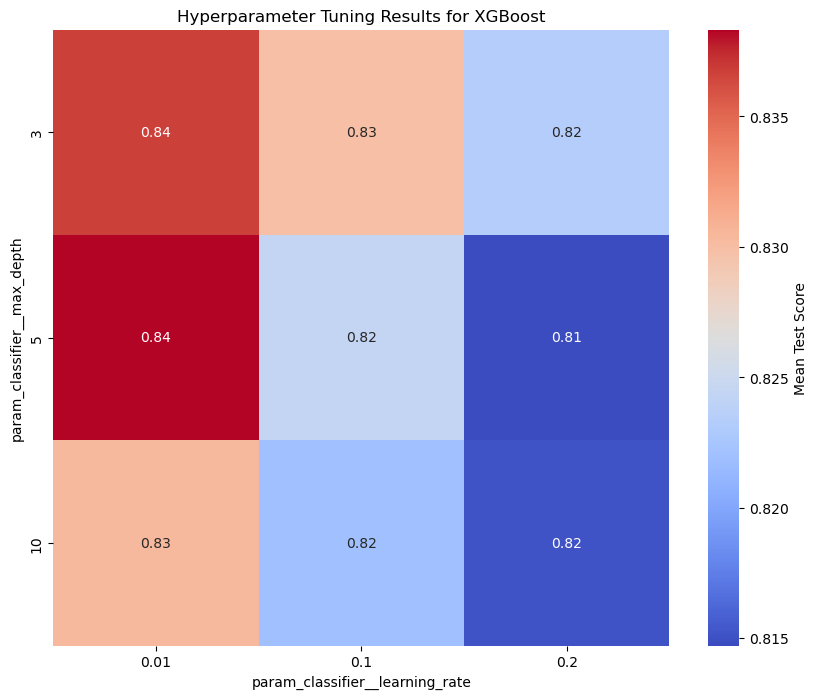

Plot saved to ../output\XGBoost_hyperparameter_heatmap.png
Visualizing hyperparameter heatmap for KNN...


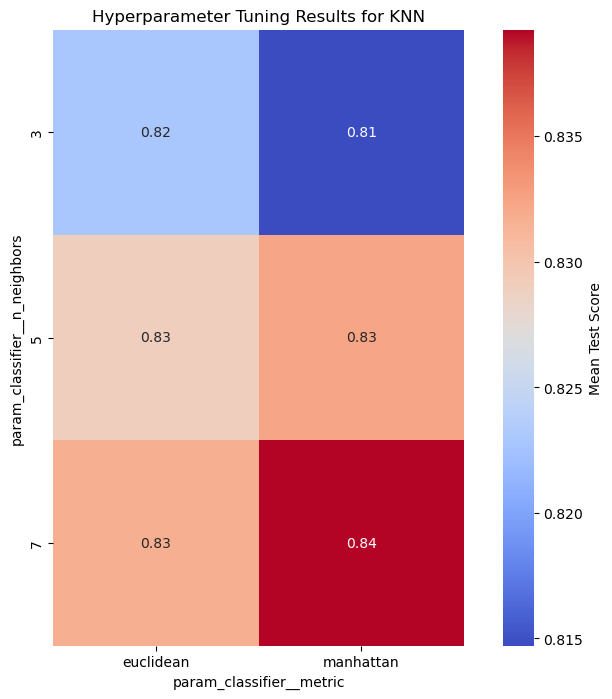

Plot saved to ../output\KNN_hyperparameter_heatmap.png
Visualizing hyperparameter heatmap for DecisionTree...


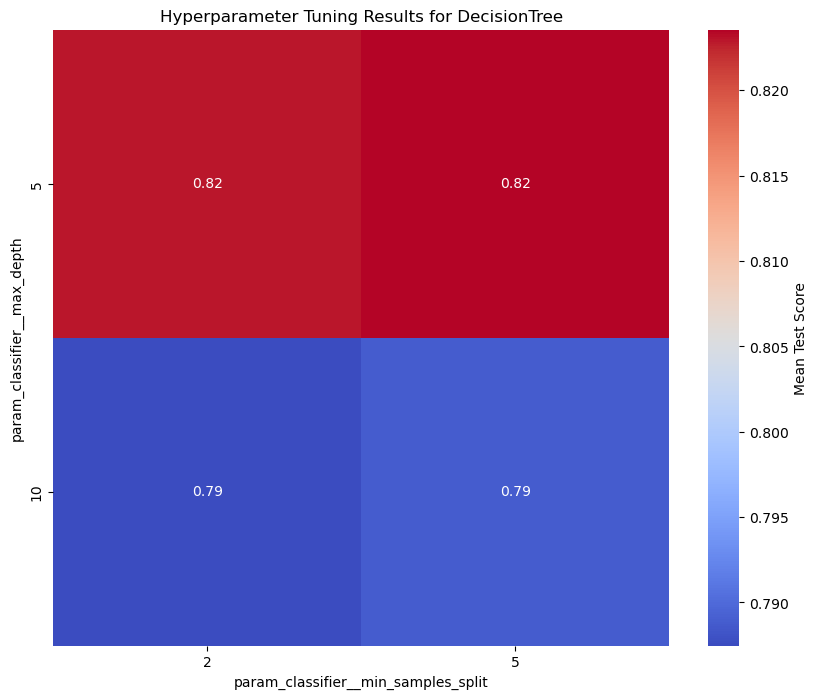

Plot saved to ../output\DecisionTree_hyperparameter_heatmap.png
Visualizing hyperparameter heatmap for LogisticRegression...


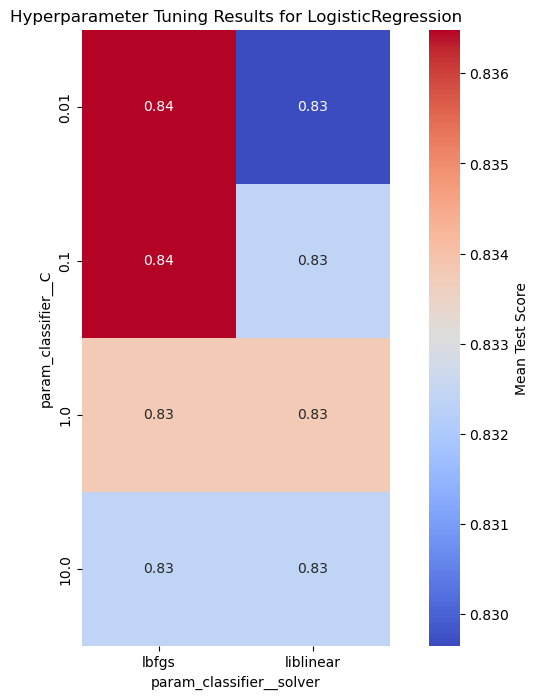

Plot saved to ../output\LogisticRegression_hyperparameter_heatmap.png


In [30]:
# Iterate through all models and visualize their hyperparameter heatmaps
for model_name, param_grid in param_grids.items():
    print(f"Visualizing hyperparameter heatmap for {model_name}...")

    # Perform GridSearchCV for the current model
    grid_search = GridSearchCV(
        estimator=pipelines[model_name],
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )
    grid_search.fit(X_train_selected, y_train)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Define the pivot table structure based on the model's hyperparameters
    pivot_params = {
        'RandomForest': ('param_classifier__max_depth', 'param_classifier__n_estimators'),
        'XGBoost': ('param_classifier__max_depth', 'param_classifier__learning_rate'),
        'KNN': ('param_classifier__n_neighbors', 'param_classifier__metric'),
        'DecisionTree': ('param_classifier__max_depth', 'param_classifier__min_samples_split'),
        'LogisticRegression': ('param_classifier__C', 'param_classifier__solver')
    }

    if model_name in pivot_params:
        index_param, column_param = pivot_params[model_name]
        pivot_table = results_df.pivot_table(
            values='mean_test_score',
            index=index_param,
            columns=column_param
        )

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(
            pivot_table,
            annot=True,
            cmap='coolwarm',
            square=True,
            cbar_kws={'label': 'Mean Test Score'}
        )
        plt.title(f'Hyperparameter Tuning Results for {model_name}')
        plt.xlabel(column_param)
        plt.ylabel(index_param)

        # Save the plot to the output directory
        plot_path = os.path.join(output_dir, f'{model_name}_hyperparameter_heatmap.png')
        plt.savefig(plot_path)
        plt.show()

        print(f"Plot saved to {plot_path}")
    else:
        print(f"Skipping visualization for {model_name} due to unsupported param_grid structure.")


### 8.3 Analysis of Hyperparameter Tuning Results  

The heatmaps visualize the hyperparameter tuning results for Random Forest, XGBoost, KNN, Decision Tree, and Logistic Regression models. Each heatmap shows the mean test scores for different combinations of hyperparameters, helping identify the optimal settings for each model. Below is a detailed analysis:

#### 1. Random Forest  
    Observations:  
    The heatmap evaluates combinations of max_depth (5 and 10) and n_estimators (50, 100, 200).  
    The highest mean test score (0.84) is observed across all combinations when max_depth=5, regardless of the number of estimators.  
    Increasing max_depth to 10 slightly reduces performance (0.839–0.840).  
    Best Parameters:  
    max_depth=5  
    n_estimators=50  

    Insights:    
    A smaller tree depth (5) combined with fewer estimators (50) optimizes performance, likely preventing overfitting while maintaining predictive accuracy.  

#### 2. XGBoost  
    Observations:  
    The heatmap evaluates combinations of max_depth (3, 5, 10) and learning_rate (0.01, 0.1, 0.2).  
    The highest mean test score (0.84) is achieved with:  
    max_depth=3 and learning_rate=0.01.  
    Increasing max_depth or learning_rate reduces performance slightly (0.81–0.83).  

    Best Parameters:  
    max_depth=3  
    learning_rate=0.01  

    Insights:  
    A shallow tree depth combined with a low learning rate optimizes performance by allowing the model to learn gradually without overfitting.  

#### 3. KNN  
    Observations:  
    The heatmap evaluates combinations of n_neighbors (3, 5, 7) and metric (euclidean, manhattan).  
    The highest mean test score (0.84) is achieved with:  
    n_neighbors=7 and metric=manhattan.  
    Lower values for n_neighbors (3 or 5) result in slightly reduced performance (0.81–0.83).  

    Best Parameters:  
    n_neighbors=7  
    metric=manhattan  

    Insights:  
    Using more neighbors (7) and the Manhattan distance metric improves performance by balancing local sensitivity and global prediction accuracy.  

#### 4. Decision Tree  
    Observations:  
    The heatmap evaluates combinations of max_depth (5, 10) and min_samples_split (2, 5).  
    The highest mean test score (0.82) is observed when:  
    max_depth=5, regardless of the value for min_samples_split.  
    Increasing max_depth to 10 reduces performance (0.79), likely due to overfitting.  

    Best Parameters:  
    max_depth=5  
    min_samples_split=2 or 5  

    Insights:  
    A smaller tree depth optimizes performance by preventing overfitting while maintaining sufficient complexity for accurate predictions.  

#### 5. Logistic Regression  
    Observations: 
    Regularization Strength (param_classifier__C):  
    The best test score (0.84) is achieved when C=0.01, indicating that stronger regularization improves model performance.  
    As C increases to 1 and 10 (weaker regularization), performance slightly declines to 0.83.  

    Solver (param_classifier__solver):  
    The lbfgs solver consistently outperforms liblinear across all values of C.  
    The highest score (0.84) is achieved with the combination of C=0.01 and solver=lbfgs.  

    Overall Performance:  
    The heatmap shows that Logistic Regression achieves a maximum mean test score of 0.84, comparable to Random Forest, XGBoost, and KNN after tuning.  

    Best Parameters for Logistic Regression  
    C=0.01 (stronger regularization)  
    solver=lbfgs   

    Insights
    Impact of Regularization (C):  
    Stronger regularization (C=0.01) prevents overfitting by penalizing large coefficients, which is particularly important in datasets with potential multicollinearity or noise.  
    Weaker regularization (C=10) reduces model performance slightly, as it allows larger coefficients that may overfit the training data.  

    Solver Selection:  
    The lbfgs solver performs better than liblinear, likely due to its efficiency in handling larger datasets and its ability to optimize multiclass problems (if needed).  

#### Comparison with Other Models:  
Logistic Regression matches the top-performing models (Random Forest, XGBoost, and KNN) in terms of mean test score (0.84) after hyperparameter tuning.  

Its simplicity and interpretability make it a strong contender for heart disease prediction, especially in medical contexts where understanding feature importance is critical.  

#### Summary of Hyperparameter Tuning Results

| Model               | Best Parameters                                | Best Mean Test Score |
|---------------------|-----------------------------------------------|----------------------|
| Random Forest       | {'max_depth': 5, 'n_estimators': 50}          | 0.84                |
| XGBoost             | {'max_depth': 3, 'learning_rate': 0.01}       | 0.84                |
| KNN                 | {'n_neighbors': 7, 'metric': 'manhattan'}     | 0.84                |
| Decision Tree       | {'max_depth': 5, 'min_samples_split': 2 or 5} | 0.82                |
| Logistic Regression | {'C': 0.01, 'solver': 'lbfgs'}                | 0.84                |  



#### Conclusion  
Logistic Regression achieves optimal performance with strong regularization (C=0.01) and the efficient lbfgs solver.  
Its performance is comparable to Random Forest, XGBoost, and KNN after tuning.  

Considering its simplicity, interpretability, and competitive performance, Logistic Regression remains an excellent choice for heart disease prediction tasks in clinical applications!

## 9. Model Evaluation

Evaluating RandomForest model...
Evaluating XGBoost model...
Evaluating KNN model...
Evaluating DecisionTree model...
Evaluating LogisticRegression model...
Model Evaluation Metrics:
                    Accuracy  Precision    Recall  F1-Score   AUC-ROC
RandomForest        0.793478   0.801887  0.833333  0.817308  0.881396
XGBoost             0.782609   0.781818  0.843137  0.811321  0.853539
KNN                 0.760870   0.773585  0.803922  0.788462  0.831301
DecisionTree        0.782609   0.803922  0.803922  0.803922  0.838235
LogisticRegression  0.793478   0.801887  0.833333  0.817308  0.890363


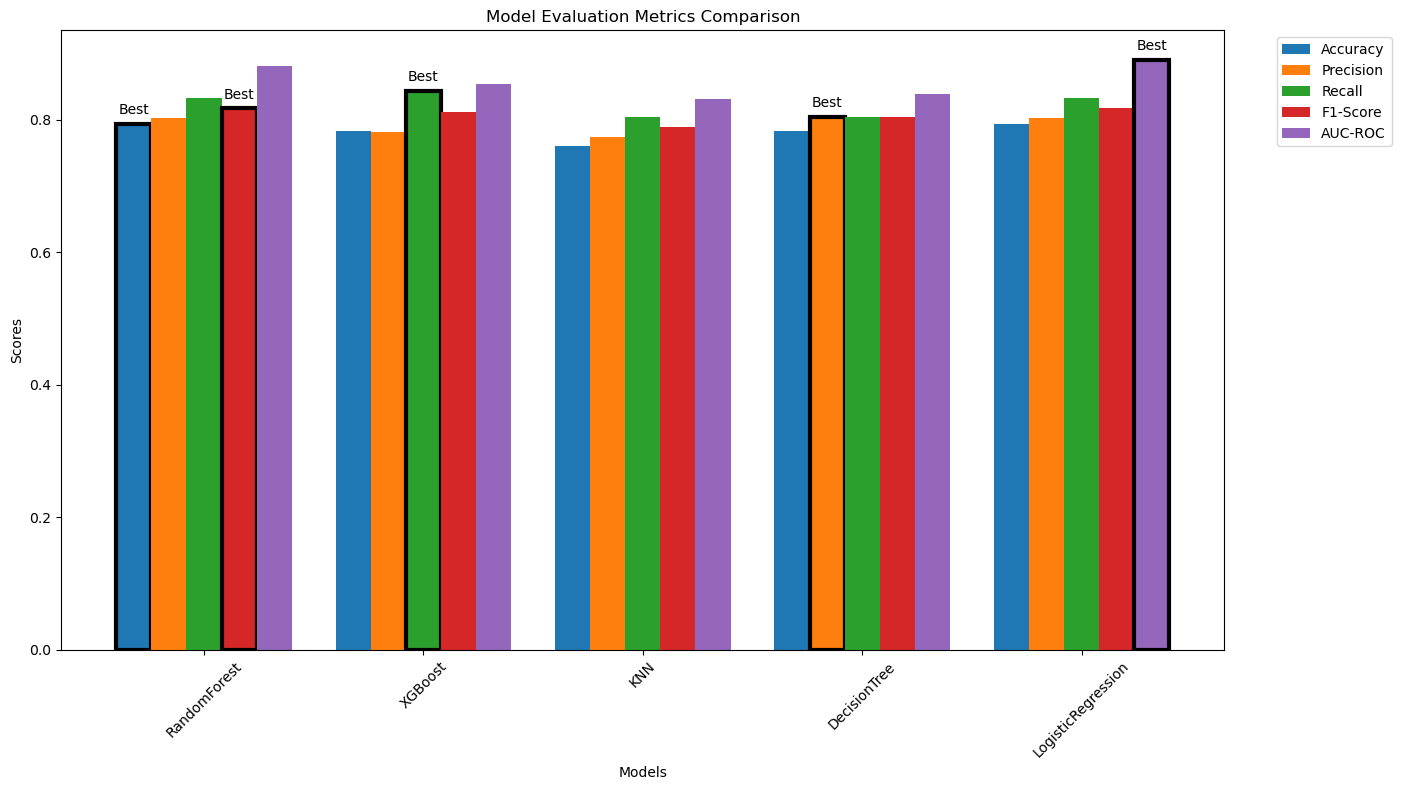

Plot saved to ../output\model_evaluation_metrics_comparison.png
The best model after hyperparameter tuning is: LogisticRegression
Evaluation Results for All Models:

RandomForest:
  Accuracy: 0.7934782608695652
  Precision: 0.8018867924528302
  Recall: 0.8333333333333334
  F1-Score: 0.8173076923076923
  AUC-ROC: 0.8813964610234338
  Confusion Matrix: [[61, 21], [17, 85]]

XGBoost:
  Accuracy: 0.782608695652174
  Precision: 0.7818181818181819
  Recall: 0.8431372549019608
  F1-Score: 0.8113207547169812
  AUC-ROC: 0.8535389765662362
  Confusion Matrix: [[58, 24], [16, 86]]

KNN:
  Accuracy: 0.7608695652173914
  Precision: 0.7735849056603774
  Recall: 0.803921568627451
  F1-Score: 0.7884615384615384
  AUC-ROC: 0.8313008130081301
  Confusion Matrix: [[58, 24], [20, 82]]

DecisionTree:
  Accuracy: 0.782608695652174
  Precision: 0.803921568627451
  Recall: 0.803921568627451
  F1-Score: 0.803921568627451
  AUC-ROC: 0.8382352941176471
  Confusion Matrix: [[62, 20], [20, 82]]

LogisticRegression

In [31]:
# Evaluate each model after hyperparameter tuning
evaluation_results = {}

# Loop through each model and evaluate its performance
for name, model in best_models.items():
    print(f"Evaluating {name} model...")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

    # Calculate evaluation metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba),
        'Confusion Matrix': confusion_matrix(y_test, y_pred).tolist()  # Convert to list for better readability
    }
    
    # Store the results
    evaluation_results[name] = metrics

# Convert evaluation results to a DataFrame for better readability (excluding confusion matrix)
metrics_df = pd.DataFrame({k: {m: v for m, v in metrics.items() if m != 'Confusion Matrix'} for k, metrics in evaluation_results.items()}).T

# Print the metrics as a table
print("Model Evaluation Metrics:")
print(metrics_df)

# Plot all metrics for all models in a single plot (excluding confusion matrix)
ax = metrics_df.drop(columns=['Confusion Matrix'], errors='ignore').plot(kind='bar', figsize=(14, 8), width=0.8)
plt.title("Model Evaluation Metrics Comparison")
plt.xlabel("Models")
plt.ylabel("Scores")
plt.xticks(rotation=45)
plt.legend(loc="upper right", bbox_to_anchor=(1.15, 1))
plt.tight_layout()

# Highlight the best scores for each metric and add a label
for metric in metrics_df.columns:
    if metric != 'Confusion Matrix':  # Skip confusion matrix
        best_model_idx = metrics_df[metric].idxmax()
        best_score = metrics_df[metric].max()
        bar_idx = list(metrics_df.index).index(best_model_idx)
        patch = ax.patches[bar_idx + len(metrics_df) * metrics_df.columns.get_loc(metric)]
        patch.set_edgecolor('black')
        patch.set_linewidth(3)
        # Add a label for the best score
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            patch.get_height() + 0.01,
            'Best',
            ha='center',
            va='bottom',
            fontsize=10,
            color='black'
        )

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'model_evaluation_metrics_comparison.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")

# Identify the best model based on AUC-ROC
best_model_name = max(evaluation_results, key=lambda x: evaluation_results[x]['AUC-ROC'])

# Display the best model and evaluation results for all models
print(f"The best model after hyperparameter tuning is: {best_model_name}")
print("Evaluation Results for All Models:")
for model_name, metrics in evaluation_results.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")


### 9.1. Visualize the ROC Curve for the best model

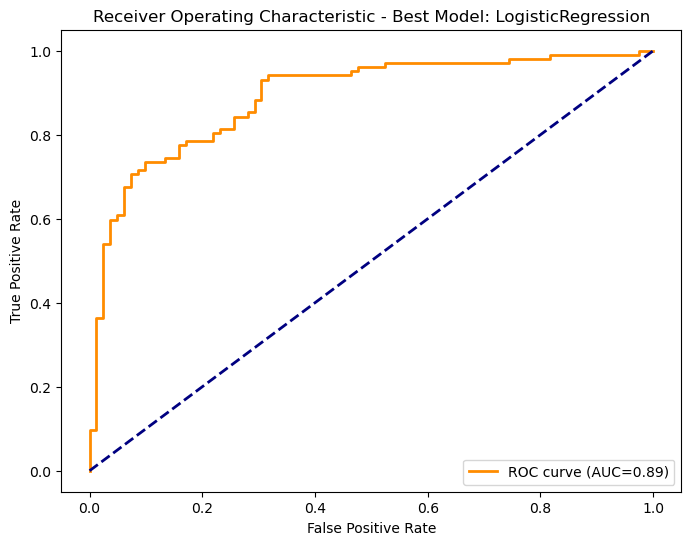

ROC curve plot saved to ../output\roc_curve.png


In [32]:
# Calculate AUC
auc_roc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={auc_roc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic - Best Model: {best_model_name}')
plt.legend(loc="lower right")

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'roc_curve.png')
plt.savefig(plot_path)
plt.show()

print(f"ROC curve plot saved to {plot_path}")



The ROC curve demonstrates that the classification model performs well, with an AUC of 0.89.

The steep rise near the Y-axis indicates that the model achieves high sensitivity with minimal false positives at optimal thresholds.

This visualization is crucial for selecting an appropriate classification threshold based on the trade-off between sensitivity and specificity, depending on business requirements or risk tolerance.

In summary, this ROC curve indicates that the model is effective at predicting heart disease outcomes, making it suitable for deployment or further refinement if needed.

### 9.2. Visualize the confusion matrix for the best model

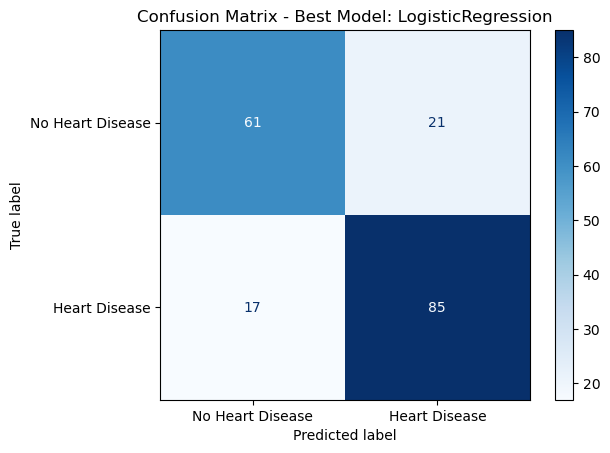

Confusion matrix plot saved to ../output\confusion_matrix.png


In [33]:
# Plot the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Heart Disease', 'Heart Disease'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix - Best Model: {best_model_name}')

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'confusion_matrix.png')
plt.savefig(plot_path)
plt.show()

print(f"Confusion matrix plot saved to {plot_path}")

Strengths of the Model  
The high number of true positives (85) demonstrates that the model effectively identifies cases of heart disease.  
Precision and recall values are both strong, indicating balanced performance in minimizing false positives and false negatives.  
Accuracy aligns with previous evaluations, confirming consistent performance across metrics.  

Weaknesses  
The presence of false positives (21) may lead to unnecessary concern or further medical testing for individuals misclassified as having heart disease.  
False negatives (17) indicate missed diagnoses, which could have serious implications in a medical context.  

The confusion matrix reaffirms that Logistic Regression is a reliable model for heart disease prediction, with strong performance across key metrics such as accuracy, precision, recall, and F1-score. However, efforts could be made to further reduce false negatives to enhance diagnostic reliability in critical applications like healthcare.

### 9.2. Create a SHAP Explainer

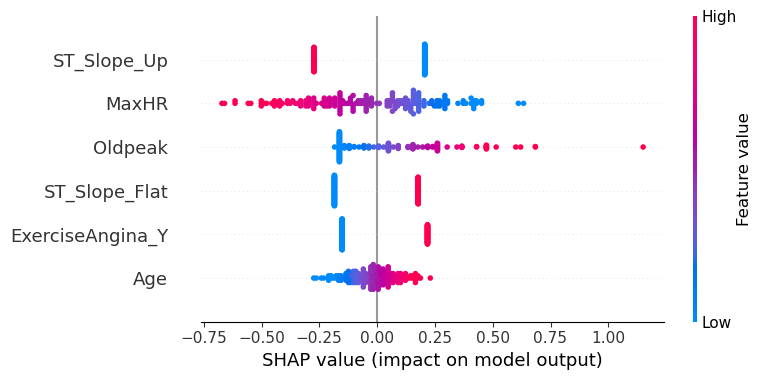

<Figure size 640x480 with 0 Axes>

SHAP summary plot saved to ../output\shap_summary_plot.png


In [34]:
# Use the best logistic regression model for SHAP analysis
logistic_model = best_models['LogisticRegression'].named_steps['classifier']

# Create a SHAP explainer for the logistic regression model
explainer = shap.Explainer(logistic_model, X_train_selected)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_selected)

# Visualize the SHAP summary plot
shap.summary_plot(shap_values, X_test_selected, feature_names=selected_features_final)

# Save the SHAP summary plot to the output directory
plot_path = os.path.join(output_dir, 'shap_summary_plot.png')
plt.savefig(plot_path)
plt.show()

print(f"SHAP summary plot saved to {plot_path}")

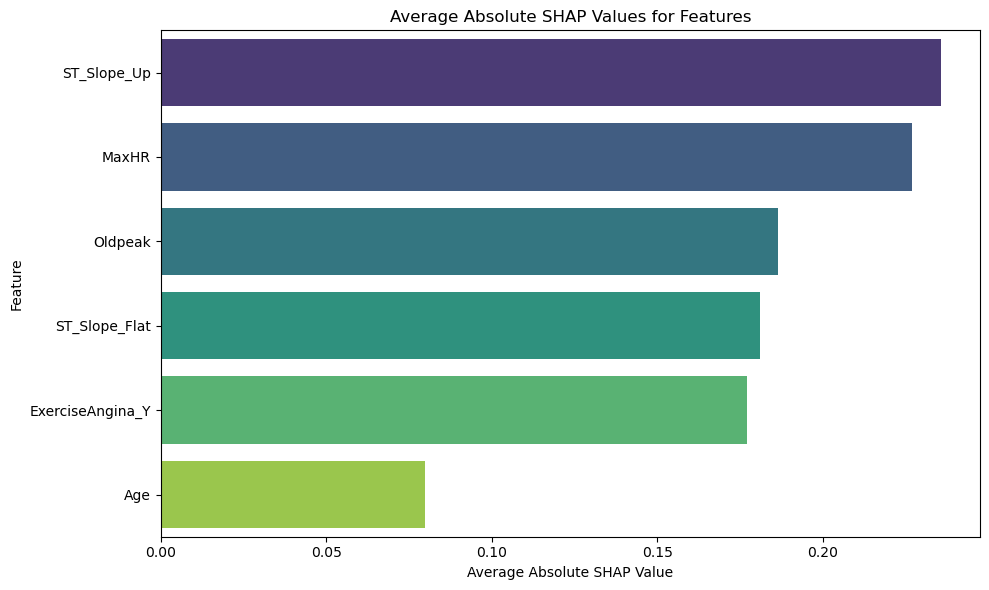

Plot saved to ../output\average_absolute_shap_values.png


In [39]:
# Calculate the average absolute SHAP values for each feature
avg_abs_shap = np.mean(np.abs(shap_values.values), axis=0)

# Create a DataFrame to display the results
shap_summary = pd.DataFrame({
    'Feature': selected_features_final,
    'Average Absolute SHAP Value': avg_abs_shap
}).sort_values(by='Average Absolute SHAP Value', ascending=False)

# Generate a bar plot for the average absolute SHAP values
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Absolute SHAP Value', y='Feature', data=shap_summary, palette='viridis')
plt.title('Average Absolute SHAP Values for Features')
plt.xlabel('Average Absolute SHAP Value')
plt.ylabel('Feature')
plt.tight_layout()

# Save the plot to the output directory
plot_path = os.path.join(output_dir, 'average_absolute_shap_values.png')
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")

### 9.3 Key Observations

#### Metric Comparisons  

Accuracy:  
Logistic Regression and Random Forest achieve the highest accuracy (0.793), outperforming other models.  
XGBoost and Decision Tree follow closely at 0.783, while KNN has the lowest accuracy (0.761).

Precision:  
Decision Tree has the highest precision (0.804), indicating fewer false positives.  
Logistic Regression and Random Forest are tied with a close second (0.802).  
XGBoost and KNN rank lower in precision.  

Recall:  
XGBoost achieves the highest recall (0.843), emphasizing its ability to identify true positives effectively.  
Logistic Regression and Random Forest are slightly behind (0.833), while KNN and Decision Tree have lower recall scores.  

F1-Score:  
Logistic Regression and Random Forest are tied at the top with an F1-Score of 0.817, reflecting balanced precision and recall.  
XGBoost follows closely (0.811), while Decision Tree and KNN score slightly lower.  

AUC-ROC:  
Logistic Regression has the highest AUC-ROC score (0.890), indicating superior overall performance in distinguishing between positive and negative classes.  
Random Forest is a close second (0.881), followed by XGBoost (0.854) and Decision Tree (0.838). KNN has the lowest AUC-ROC score (0.831).  

#### Model Selection:  
Logistic Regression consistently performs well across all metrics, particularly excelling in AUC-ROC (highest at 0.890) and maintaining strong scores in accuracy, precision, recall, and F1-Score.  

Random Forest is competitive, especially in AUC-ROC (second-best at 0.881) and F1-Score but slightly trails in recall compared to XGBoost.  

XGBoost shows strong recall but falls short in AUC-ROC compared to Logistic Regression.  

#### Recommendation  
Logistic Regression is the best model for heart disease prediction due to its:  
Highest AUC-ROC score, indicating excellent classification performance.  
Balanced precision, recall, and F1-Score metrics.  

This model is particularly suitable for medical applications where distinguishing between positive and negative cases is critical.  

#### Confusion Matrix Summary  
The confusion matrix for Logistic Regression reveals:  
True Positives (TP): 85 cases of heart disease correctly identified.  
True Negatives (TN): 61 cases correctly classified as not having heart disease.  
False Positives (FP): 21 cases incorrectly predicted as having heart disease.  
False Negatives (FN): 17 cases of heart disease missed by the model.  

Metrics Derived from Confusion Matrix:
Accuracy: 79.3%  
Precision: 80.2%  
Recall: 83.3%  
F1-Score: 81.7%  

The confusion matrix confirms that Logistic Regression achieves a good balance between minimizing false positives and false negatives, making it suitable for medical applications where both types of errors have significant implications.  

#### SHAP Analysis Summary  
The SHAP analysis highlights the importance of individual features in predicting heart disease.  

Key Features Impacting Predictions:  
ST_Slope_Up:  
Most influential feature with predominantly negative SHAP values, indicating its protective role against heart disease.  

MaxHR:  
Second most important feature; lower values increase risk, while higher values are protective.  

Oldpeak:  
Strongly associated with increased likelihood of heart disease; higher values contribute positively to predictions.  

ST_Slope_Flat:  
Consistently increases risk; a flat ST slope is a significant predictor of heart disease.  

ExerciseAngina_Y:  
Presence of exercise-induced angina increases risk significantly.  

Age:  
Older age generally increases risk, but its impact is less pronounced compared to other features.  

Mean Absolute SHAP Values:  
The bar chart ranking confirms that ST_Slope_Up, MaxHR, and Oldpeak are the top three most impactful features on model predictions.  

#### Overall Conclusion  
Combining insights from the hyperparameter tuning, evaluation metrics, confusion matrix, and SHAP analysis:  

Logistic Regression is the best-performing model for predicting heart disease due to its high AUC-ROC score, balanced metrics, and interpretability.  

## 10. Save the Model

In [35]:
# Save the best model
with open('../output/best_model.pkl', 'wb') as f:
    pickle.dump(best_models[best_model_name].named_steps['classifier'], f)

# Save the selector
with open('../output/selector.pkl', 'wb') as f:
    pickle.dump(selector, f)

# Save the scaler
with open('../output/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the one-hot encoded feature names
with open('../output/onehot_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

## 11. Model Deployment

### 11.1. Model Deployment - Preset Moderate Example

In [45]:
# Example 1: Moderate Indicators

# Load the saved model and necessary objects
with open('../output/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
with open('../output/selector.pkl', 'rb') as f:
    loaded_selector = pickle.load(f)
with open('../output/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
with open('../output/onehot_features.pkl', 'rb') as f:
    onehot_features = pickle.load(f)

# Define a preset example
moderate_example_data = pd.DataFrame({
    'Age': [60],
    'Sex': ['M'],
    'ChestPainType': ['ATA'],
    'RestingBP': [70],
    'Cholesterol': [289],
    'FastingBS': [1],
    'RestingECG': ['ST'],
    'MaxHR': [172],
    'ExerciseAngina': ['Y'],
    'Oldpeak': [1],
    'ST_Slope': ['Flat']
})

# One-hot encode categorical variables
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
moderate_example_data = pd.get_dummies(moderate_example_data, columns=categorical_cols, drop_first=True)

# Create age groups
moderate_example_data['AgeGroup'] = pd.cut(moderate_example_data['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
moderate_example_data = pd.get_dummies(moderate_example_data, columns=['AgeGroup'], drop_first=True)

# Create cholesterol level categories
moderate_example_data['CholesterolLevel'] = pd.cut(moderate_example_data['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
moderate_example_data = pd.get_dummies(moderate_example_data, columns=['CholesterolLevel'], drop_first=True)

# Scale numerical features
numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
moderate_example_data[numerical_cols] = loaded_scaler.transform(moderate_example_data[numerical_cols])

# Add missing features with zeros
for feature in onehot_features:
    if feature not in moderate_example_data.columns:
        moderate_example_data[feature] = 0

# Reorder features to match the original dataset
moderate_example_data = moderate_example_data[onehot_features]

# Display the feature-engineered data for the example without False data
filtered_columns = moderate_example_data.loc[:, (moderate_example_data != False).any(axis=0)].drop(columns=['Age', 'MaxHR', 'Oldpeak'])
print("Feature-Engineered Data for Moderate Example (Filtered):")
print(filtered_columns.to_string(index=False))

# Select features
example_data_selected = loaded_selector.transform(moderate_example_data)

# Check the preprocessed input data
print("Preprocessed Input Data:")
print(example_data_selected)

# Generate prediction and prediction probabilities
prediction = loaded_model.predict(example_data_selected)
prediction_proba = loaded_model.predict_proba(example_data_selected)

print("Heart Disease Risk Prediction:", prediction)
print("Prediction Probabilities:", prediction_proba)

Feature-Engineered Data for Moderate Example (Filtered):
 AgeGroup_MiddleAged  CholesterolLevel_High
                True                   True
Preprocessed Input Data:
[[0.68831845 1.38292822 0.10566353 0.         0.         0.        ]]
Heart Disease Risk Prediction: [0]
Prediction Probabilities: [[0.50533409 0.49466591]]


The output indicates that the model is predicting "no heart disease" with a probability of approximately 50% and "heart disease" with a probability of approximately 49%. This suggests that the model is not very confident in its prediction, but it still leans towards "no heart disease."

### 11.3. Model Deployment - Preset Extreme Example

In [42]:
# Example 2: Severe indicators

# Load the saved model and necessary objects
with open('../output/best_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)
with open('../output/selector.pkl', 'rb') as f:
    loaded_selector = pickle.load(f)
with open('../output/scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)
with open('../output/onehot_features.pkl', 'rb') as f:
    onehot_features = pickle.load(f)

# Define a more severe example
severe_example_data = pd.DataFrame({
    'Age': [70],
    'Sex': ['M'],
    'ChestPainType': ['ASY'],
    'RestingBP': [180],
    'Cholesterol': [300],
    'FastingBS': [1],
    'RestingECG': ['LVH'],
    'MaxHR': [100],
    'ExerciseAngina': ['Y'],
    'Oldpeak': [3],
    'ST_Slope': ['Down']
})

# Repeat the preprocessing steps for the severe example
severe_example_data = pd.get_dummies(severe_example_data, columns=categorical_cols, drop_first=True)
severe_example_data['AgeGroup'] = pd.cut(severe_example_data['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
severe_example_data = pd.get_dummies(severe_example_data, columns=['AgeGroup'], drop_first=True)
severe_example_data['CholesterolLevel'] = pd.cut(severe_example_data['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
severe_example_data = pd.get_dummies(severe_example_data, columns=['CholesterolLevel'], drop_first=True)
severe_example_data[numerical_cols] = loaded_scaler.transform(severe_example_data[numerical_cols])

for feature in onehot_features:
    if feature not in severe_example_data.columns:
        severe_example_data[feature] = 0

severe_example_data = severe_example_data[onehot_features]

# Display the feature-engineered data for the severe example without False data
filtered_columns = severe_example_data.loc[:, (severe_example_data != False).any(axis=0)].drop(columns=['Age', 'MaxHR', 'Oldpeak'])
print("Feature-Engineered Data for Severe Example (Filtered):")
print(filtered_columns.to_string(index=False))

# Select features
severe_example_data_selected = loaded_selector.transform(severe_example_data)

# Generate prediction and prediction probabilities for the severe example
severe_prediction = loaded_model.predict(severe_example_data_selected)
severe_prediction_proba = loaded_model.predict_proba(severe_example_data_selected)

print("Severe Example - Heart Disease Risk Prediction:", severe_prediction)
print("Severe Example - Prediction Probabilities:", severe_prediction_proba)

Feature-Engineered Data for Severe Example (Filtered):
 AgeGroup_Senior  CholesterolLevel_High
            True                   True
Severe Example - Heart Disease Risk Prediction: [1]
Severe Example - Prediction Probabilities: [[0.20975313 0.79024687]]


The output for the severe example indicates that the model is predicting "heart disease" with a probability of approximately 79%. This suggests that the model is capable of identifying severe cases correctly.

### 11.4. Generate Heart Disease Prediction from User Input

In [46]:
def generate_prediction():
    # Load the saved model and necessary objects
    with open('../output/best_model.pkl', 'rb') as f:
        loaded_model = pickle.load(f)
    with open('../output/selector.pkl', 'rb') as f:
        loaded_selector = pickle.load(f)
    with open('../output/scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    with open('../output/onehot_features.pkl', 'rb') as f:
        onehot_features = pickle.load(f)

    # Ask for user input
    age = float(input("Enter your age: "))
    sex = input("Enter your sex (M/F): ")
    chest_pain_type = input("Enter your chest pain type (ATA/NAP/ASY/TA): ")
    resting_bp = float(input("Enter your resting blood pressure: "))
    cholesterol = float(input("Enter your cholesterol level: "))
    fasting_bs = float(input("Enter your fasting blood sugar (0/1): "))
    resting_ecg = input("Enter your resting ECG result (Normal/ST/LVH): ")
    max_hr = float(input("Enter your maximum heart rate: "))
    exercise_angina = input("Do you have exercise angina? (Y/N): ")
    oldpeak = float(input("Enter your old peak value: "))
    st_slope = input("Enter your ST slope (Up/Flat/Down): ")

    # Display user inputs
    print("\n--- User Input ---")
    print(f"Age: {age}")
    print(f"Sex: {sex}")
    print(f"Chest Pain Type: {chest_pain_type}")
    print(f"Resting Blood Pressure: {resting_bp}")
    print(f"Cholesterol Level: {cholesterol}")
    print(f"Fasting Blood Sugar: {fasting_bs}")
    print(f"Resting ECG Result: {resting_ecg}")
    print(f"Maximum Heart Rate: {max_hr}")
    print(f"Exercise Angina: {exercise_angina}")
    print(f"Oldpeak Value: {oldpeak}")
    print(f"ST Slope: {st_slope}")

    # Create a DataFrame with user input
    user_data = pd.DataFrame({
        'Age': [age],
        'Sex': [sex],
        'ChestPainType': [chest_pain_type],
        'RestingBP': [resting_bp],
        'Cholesterol': [cholesterol],
        'FastingBS': [fasting_bs],
        'RestingECG': [resting_ecg],
        'MaxHR': [max_hr],
        'ExerciseAngina': [exercise_angina],
        'Oldpeak': [oldpeak],
        'ST_Slope': [st_slope]
    })

    # One-hot encode categorical variables
    categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
    user_data = pd.get_dummies(user_data, columns=categorical_cols, drop_first=True)

    # Create age groups
    user_data['AgeGroup'] = pd.cut(user_data['Age'], bins=[0, 30, 45, 60, np.inf], labels=['Young', 'Adult', 'MiddleAged', 'Senior'])
    user_data = pd.get_dummies(user_data, columns=['AgeGroup'], drop_first=True)

    # Create cholesterol level categories
    user_data['CholesterolLevel'] = pd.cut(user_data['Cholesterol'], bins=[0, 200, 240, np.inf], labels=['Low', 'Medium', 'High'])
    user_data = pd.get_dummies(user_data, columns=['CholesterolLevel'], drop_first=True)

    # Scale numerical features
    numerical_cols = ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak']
    user_data[numerical_cols] = loaded_scaler.transform(user_data[numerical_cols])

    # Add missing features with zeros
    for feature in onehot_features:
        if feature not in user_data.columns:
            user_data[feature] = 0

    # Reorder features to match the original dataset
    user_data = user_data[onehot_features]

    # Display the feature-engineered data without False data
    filtered_columns = user_data.loc[:, (user_data != False).any(axis=0)].drop(columns=['Age', 'MaxHR', 'Oldpeak'])
    print("\n--- Feature-Engineered Data (Filtered) ---")
    print(filtered_columns.to_string(index=False))

    # Select features
    user_data_selected = loaded_selector.transform(user_data)

    # Generate prediction
    prediction = loaded_model.predict(user_data_selected)

    # Display prediction result
    prediction_label = "Risk of Heart Disease Detected" if prediction[0] == 1 else "Low Risk of Heart Disease Detected"

    print("\n--- Prediction ---")
    print(prediction_label)

# Call the function to generate a prediction
generate_prediction()



--- User Input ---
Age: 60.0
Sex: M
Chest Pain Type: ASY
Resting Blood Pressure: 170.0
Cholesterol Level: 170.0
Fasting Blood Sugar: 0.0
Resting ECG Result: Normal
Maximum Heart Rate: 180.0
Exercise Angina: N
Oldpeak Value: 0.0
ST Slope: Down

--- Feature-Engineered Data (Filtered) ---
 AgeGroup_MiddleAged
                True

--- Prediction ---
Low Risk of Heart Disease Detected
